**Question 1**

Sampling the new order type and the shares, prices randomly from a uniform distibution.

In [61]:
import sys
sys.path.append("../")
import os
import numpy as np
import itertools
from dataclasses import dataclass, replace, field
from matplotlib import pyplot as plt
from typing import Optional, Mapping, Dict, Tuple, TypeVar, Iterable, Sequence, Callable, Iterator, List
from scipy.stats import norm

from rl.markov_process import MarkovProcess, NonTerminal, State
from rl.distribution import Distribution, Constant

from rl.chapter9.order_book import OrderBook, DollarsAndShares, PriceSizePairs

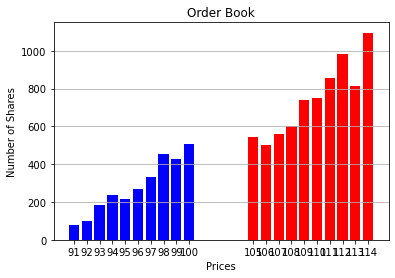

In [62]:
bids: PriceSizePairs = [DollarsAndShares(
        dollars = x,
        shares = 5*np.random.poisson(100. - (100-x)*10)
        ) for x in range(100,90,-1)]
    
asks: PriceSizePairs = [DollarsAndShares(
        dollars = x,
        shares = 5*np.random.poisson(100 - (105-x)*10)
        ) for x in range(105, 115, 1)]

book: OrderBook = OrderBook(descending_bids = bids, ascending_asks = asks)

book.display_order_book()




In [63]:
class OrderBookDynamics(MarkovProcess[OrderBook]):

        
    def __init__(self):
        self.ots = ['SL','BL','SM','BM']
        super().__init__()
    
        
        
    def transition(self, state: NonTerminal[OrderBook]) -> Distribution[State[OrderBook]]:
        ot = self.ots[np.random.randint(0,4)]
        shares = np.random.randint(5,11)
        price_perturb = np.random.randint(-10,11)
        
        import pdb
        #pdb.set_trace()
        if len(state.state.ascending_asks) == 0:
            pdb.set_trace()
            price = state.state.descending_bids[0].dollars + abs(price_perturb)
            _ , new_ob = state.state.sell_limit_order(price,shares)
            return Constant(NonTerminal(new_ob))
        
        if len(state.state.descending_bids) == 0:
            price = state.state.ascending_asks[0].dollars - abs(price_perturb)
            _ , new_ob = state.state.buy_limit_order(price,shares)
            return Constant(NonTerminal(new_ob))   
        
        price = state.state.mid_price() + price_perturb
        if ot == "SL":
            _ , new_ob = state.state.sell_limit_order(price,shares)
        
        if ot == "BL":
            _ , new_ob = state.state.buy_limit_order(price,shares)
        
        if ot == "SM":
            _ , new_ob = state.state.sell_market_order(shares)

        if ot == "BM":
            _ , new_ob = state.state.buy_market_order(shares)
        
        return Constant(NonTerminal(new_ob))

In [64]:
mp = OrderBookDynamics()


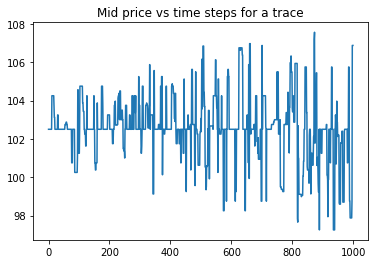

In [65]:
start_state_distribution = Constant(NonTerminal(book))
t = 1000
result = np.vstack([
        np.fromiter((s.state.mid_price() for s in itertools.islice(
        mp.simulate(start_state_distribution),
        t
        ) if (len(s.state.descending_bids) != 0 and len(s.state.ascending_asks) != 0)
        ), float) for _ in range(10)
])
plt.plot(result[0])
plt.title("Mid price vs time steps for a trace")
plt.show()

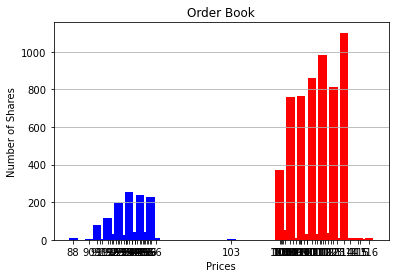

In [66]:
ctr = 1000
for s in mp.simulate(start_state_distribution):
    ctr-=1
    if not ctr:
        break
s.state.display_order_book()

We can further experiment with different distributions on the shares and prices. 